## Preparing Libraries

### Downloading Necessary Libs

In [ ]:
%%capture
!pip install unsloth
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
!pip install spacy sentence-transformers nltk rouge-score bert_score
!python -m spacy download en_core_web_md

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=cacce482dc602673d195f3675d693035c520b63ddfd7ae5790e3411fadeadf2f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Importing Libraries

In [ ]:
from datasets import Dataset, DatasetDict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import files
from wordcloud import WordCloud
from collections import defaultdict, Counter
from unsloth import FastLanguageModel, is_bfloat16_supported
from trl import SFTTrainer
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction, sentence_bleu
from transformers import GenerationConfig, TrainingArguments
from rouge_score import rouge_scorer
from bert_score import score
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import spacy
import json
import re
import numpy as np
import os
import subprocess
import asyncio
from deepgram import Deepgram
nltk.download('punkt')

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Extracting and Adjusting Data

### Extracting Data using Deepgram

In [ ]:
DEEPGRAM_API_KEY = 'e0b60f3e1fc3502237cd7851446146eb6dc84d79'

def download_audio(youtube_url, output_dir='downloads'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    command = [
        'yt-dlp',
        '--extract-audio',
        '--audio-format', 'mp3',
        '--output', f'{output_dir}/%(title)s.%(ext)s',
        '--user-agent', 'AppleWebKit/537.36 (KHTML, like Gecko)',
        youtube_url
    ]
    #'--user-agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36',

    subprocess.run(command, check=True)

    for file in os.listdir(output_dir):
        if file.endswith('.mp3'):
            return os.path.join(output_dir, file)
    return None

async def transcribe_audio(audio_file):
    dg_client = Deepgram(DEEPGRAM_API_KEY)

    with open(audio_file, 'rb') as audio:
        source = {
            "buffer": audio,
            "mimetype": "audio/mp3"
        }
        response = await dg_client.transcription.prerecorded(source)

        transcript = response['results']['channels'][0]['alternatives'][0]['transcript']
        return transcript

def save_transcript(transcript, output_file):
    with open(output_file, 'w') as f:
        f.write(transcript)

def process_youtube_video(youtube_url):
    try:
        print("Downloading and extracting audio...")
        audio_file = download_audio(youtube_url)
        if audio_file:
            print(f"Audio downloaded and saved as {audio_file}")
        else:
            print("Failed to download audio.")
            return

        print("Transcribing audio...")
        transcript = asyncio.run(transcribe_audio(audio_file))
        print("Transcription completed.")

        transcript_file = audio_file.replace('.mp3', '.txt')
        save_transcript(transcript, transcript_file)
        print(f"Transcript saved as {transcript_file}")

    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
if __name__ == "__main__":
    youtube_url = input("Enter the YouTube video URL: ")
    process_youtube_video(youtube_url)

### Adding Topic Label

In [ ]:
def add_topic_label(file_name, new_file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)

        for pair in data:
            pair["Topic"] = label

        with open(new_file_name, 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=4, ensure_ascii=False)

        print(f"The new label has been successfully added, and the new file is saved as '{new_file_name}'.")

    except FileNotFoundError:
        print(f"The file '{file_name}' was not found.")
    except json.JSONDecodeError:
        print(f"Failed to read the content of the file '{file_name}'. Ensure it is a valid JSON file.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
file_name = "study skills data.json"
new_file_name = "Study_Skills data with topic.json"
label = "Study_Skills"

add_topic_label(file_name, new_file_name)

### Combining Files

In [ ]:
def combine_json_files(file_names, output_file_name):
    combined_data = []

    try:
        for file_name in file_names:
            with open(file_name, 'r', encoding='utf-8') as file:
                data = json.load(file)
                if isinstance(data, list):
                    combined_data.extend(data)
                else:
                    print(f"Warning: The file '{file_name}' does not contain a list. Skipping.")

        with open(output_file_name, 'w', encoding='utf-8') as output_file:
            json.dump(combined_data, output_file, indent=4, ensure_ascii=False)

        print(f"All files have been successfully combined into '{output_file_name}'.")

    except FileNotFoundError as e:
        print(f"Error: One of the files was not found. {e}")
    except json.JSONDecodeError as e:
        print(f"Error: Failed to read JSON content from one of the files. {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [ ]:
file_names = [
    "Business data with Topic.json",
    "Climate data with topic.json",
    "Literature data with topic.json",
    "Public_Health data with topic.json",
    "Study_Skills data with topic.json"
]

output_file_name = "EDUC_DATA.json"

combine_json_files(file_names, output_file_name)

## Loading Data

In [ ]:
uploaded = files.upload()

Saving EDUC_DATA.json to EDUC_DATA.json


In [ ]:
with open('EDUC_DATA.json', 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

examples_by_topic = {}
seen_topics = set()

for example in raw_data:
    topic = example['Topic']
    if topic not in seen_topics:
        examples_by_topic[topic] = example
        seen_topics.add(topic)
        if len(seen_topics) == 5:
            break

In [ ]:
print("One example for each topic:")
for i, (topic, example) in enumerate(examples_by_topic.items(), 1):
    print(f"\nExample {i}:")
    print(f"Topic: {topic}")
    print(f"Question: {example['Question']}")
    print(f"Answer: {example['Answer']}")

One example for each topic:

Example 1:
Topic: Business
Question: How is trust compared to a business pyramid in the context of professional relationships?
Answer: Trust is considered the foundational level of the business pyramid, crucial for building a solid reputation and fostering effective working relationships.

Example 2:
Topic: Climate
Question: How does climate change affect our daily lives?
Answer: Climate change affects daily activities like grocery shopping, filling the gas tank, voting, and dealing with unusual weather patterns like late snowfalls.

Example 3:
Topic: Literature
Question: What is the main focus of the mini-series discussed in the text?
Answer: The mini-series focuses on reading and writing in English, specifically how to read and why it's important.

Example 4:
Topic: Public_Health
Question: How do we often think of health?
Answer: As a self-centric phenomenon that begins and ends with the individual.

Example 5:
Topic: Study_Skills
Question: What is the pr

In [ ]:
print(f"\nTotal number of examples: {len(raw_data)}")


Total number of examples: 3507


## Data Preprocessing and Analysis

### Cleaning

In [ ]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s\?\!\.\,]', '', text)
    text = re.sub(r'(.)\1+', r'\1', text)
    return ' '.join(text.split())

تحويل النص إلى أحرف صغيرة: نقوم بتحويل جميع الأحرف الكبيرة إلى أحرف صغيرة لضمان التجانس في تحليل البيانات

 إزالة الرموز غير المرغوب فيها: نزيل جميع الرموز غير الحروف والأرقام والمسافات وعلامات الاستفهام والتعجب والنقاط والفواصل.

 التخلص من الأحرف المكررة أكثر من مرة واستبدالها بمحرف واحد

 إزالة المسافات الزائدة


In [ ]:
def generate_combined_text(data: list, clean=False):
    combined_text = " ".join(
        f"{entry['Question']} {entry['Answer']}" for entry in data
    )
    if clean:
        combined_text = clean_text(combined_text)
    return combined_text

### Plotting

#### WordCloud

In [ ]:
def generate_wordcloud(text: str, title: str):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

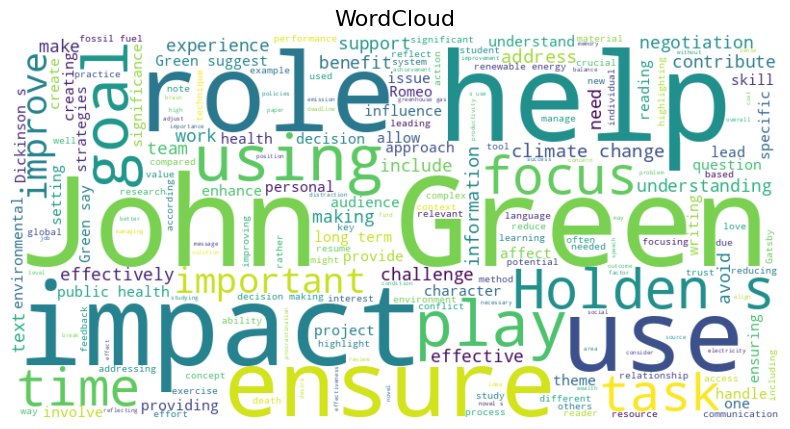

In [ ]:
raw_text = generate_combined_text(raw_data, clean=False)

generate_wordcloud(raw_text, "WordCloud")

يظهر المخطط الكلمات الاكثر ورودا و هي الاكثر تأثيرا في البيانات

#### Histogram & Pie Chart

In [ ]:
def plot_bar_chart(data):

    topic_counts = Counter(entry.get("Topic", "Unknown") for entry in data)
    topics = list(topic_counts.keys())
    counts = list(topic_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(topics, counts, color='skyblue')
    plt.xlabel('Topics', fontsize=14)
    plt.ylabel('Number of Q&A Pairs', fontsize=14)
    plt.title('Distribution of Q&A Pairs by Topic', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

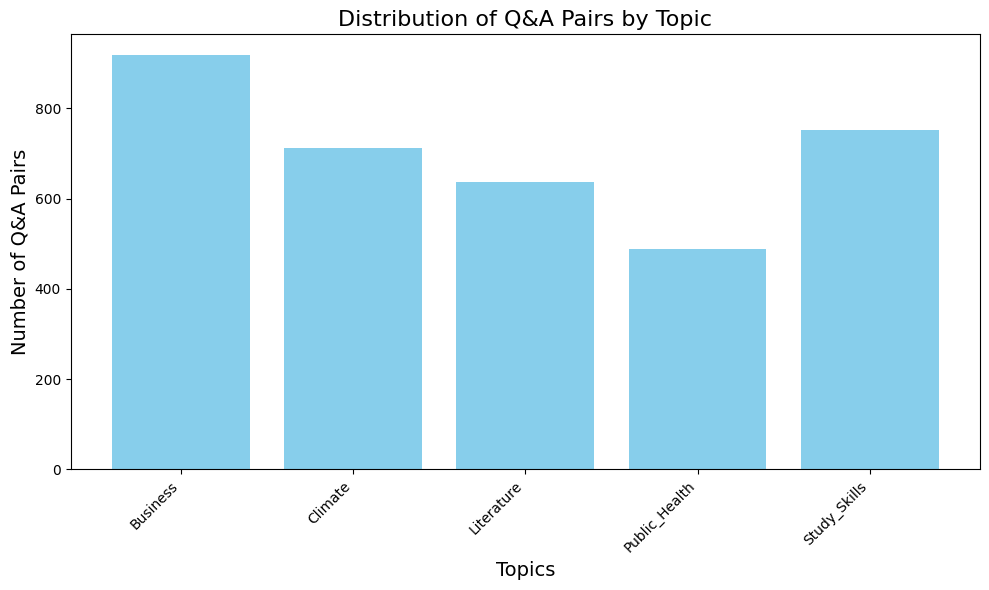

In [ ]:
plot_bar_chart(raw_data)

In [ ]:
def plot_pie_chart(data):
    topic_counts = Counter(entry.get("Topic", "Unknown") for entry in data)
    topics = list(topic_counts.keys())
    counts = list(topic_counts.values())

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=topics, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20c.colors)
    plt.title('Topic Distribution as Percentage', fontsize=16)
    plt.tight_layout()
    plt.show()

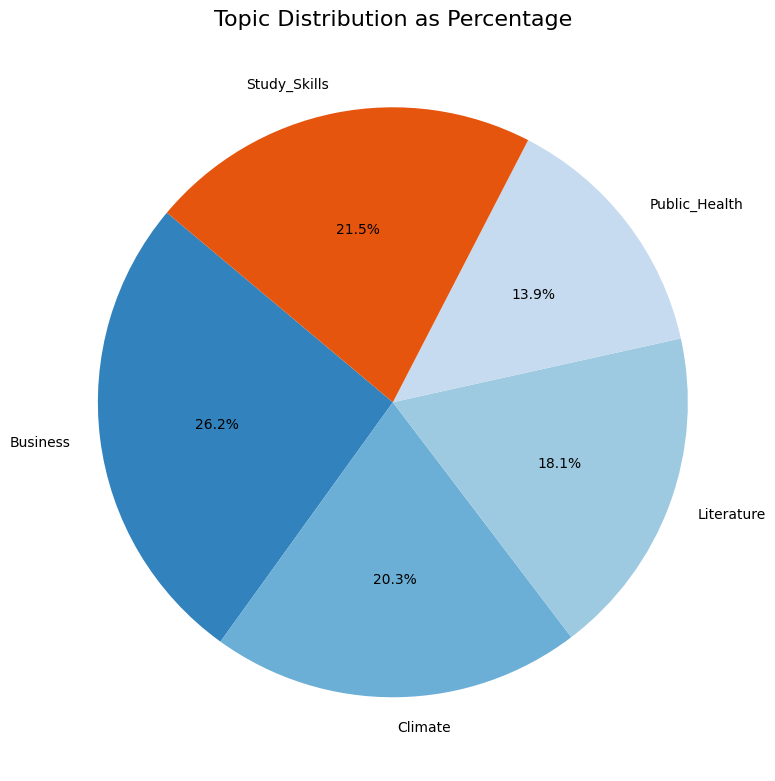

In [ ]:
plot_pie_chart(raw_data)

يمثل المخططين عدد عينات البيانات لكل

(Topic) نلاحظ وجود تفاوت في عدد العينات

#### HeatMap

اظهار العلاقة بين المواضيع

In [ ]:
def generate_heatmap(data):
    # Group Q&A pairs by topic
    topic_texts = defaultdict(str)
    for entry in data:
        topic = entry.get("Topic", "Unknown")
        combined_text = f"{entry.get('Question', '')} {entry.get('Answer', '')}"
        topic_texts[topic] += combined_text + " "

    # Prepare data for TF-IDF Vectorizer
    topics = list(topic_texts.keys())
    text_data = list(topic_texts.values())

    # Calculate TF-IDF and cosine similarity
    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(text_data)
    similarity_matrix = cosine_similarity(tfidf_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", xticklabels=topics, yticklabels=topics, cmap="Blues")
    plt.title("Topic Similarity Heatmap", fontsize=16)
    plt.xlabel("Topics", fontsize=14)
    plt.ylabel("Topics", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

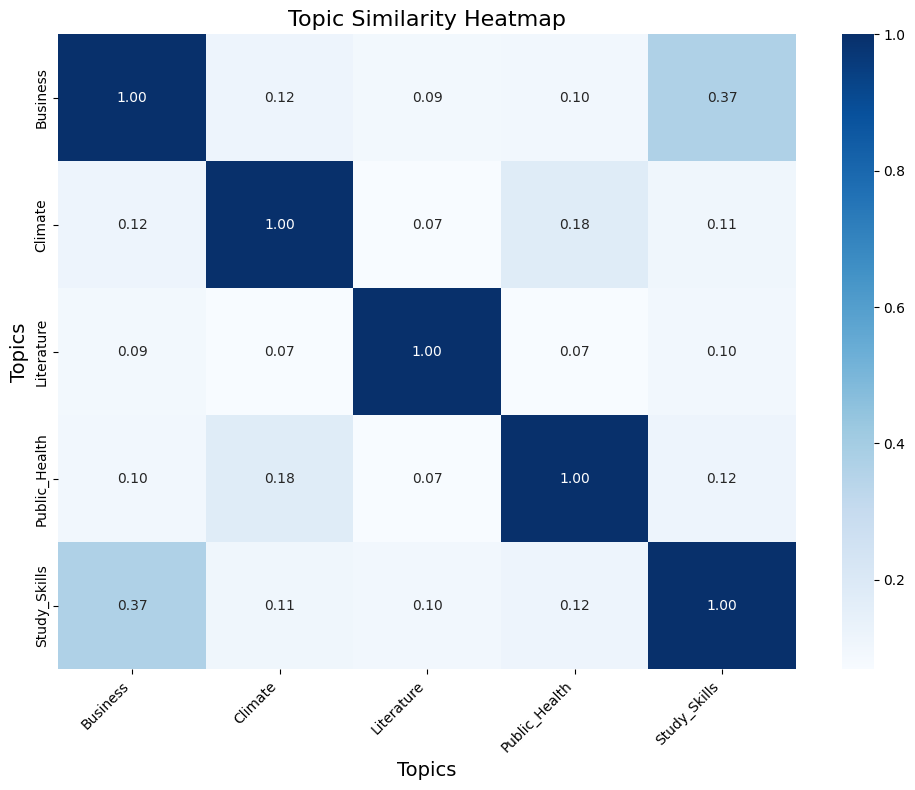

In [ ]:
generate_heatmap(raw_data)

نلاحظ من المخطط وجود علاقة ضعيفة بين المواضيع في البيانات

### Splitting Dataset

In [ ]:
def prepare_split_dataset(data: list, test_size: float = 0.13, val_size: float = 0.13, random_state: int = 42) -> DatasetDict:
    processed_data = [
        {
            "Question": entry['Question'].strip(),
            "Answer": entry['Answer'].strip(),
            "Topic": entry['Topic']
        }
        for entry in data
    ]

    # تجميع البيانات حسب الموضوع
    grouped_data = defaultdict(list)
    for entry in processed_data:
        grouped_data[entry['Topic']].append(entry)

    # Stratified split for test data
    train_val_data, test_data = [], []
    for topic, entries in grouped_data.items():
        train_val, test = train_test_split(
            entries,
            test_size=test_size,
            random_state=random_state
        )
        train_val_data.extend(train_val)
        test_data.extend(test)

    # ضبط حجم التحقق لتقسيم train-val
    adjusted_val_size = val_size / (1 - test_size)
    train_data, val_data = [], []
    for topic, entries in grouped_data.items():
        topic_train_val = [entry for entry in train_val_data if entry['Topic'] == topic]
        train, val = train_test_split(
            topic_train_val,
            test_size=adjusted_val_size,
            random_state=random_state
        )
        train_data.extend(train)
        val_data.extend(val)

    dataset_dict = DatasetDict({
        'train': Dataset.from_list(train_data),
        'validation': Dataset.from_list(val_data),
        'test': Dataset.from_list(test_data)
    })

    return dataset_dict

In [ ]:
dataset_dict = prepare_split_dataset(raw_data)

for split, dataset in dataset_dict.items():
    print(f"\n{split} split:")
    print(f"Number of examples: {len(dataset)}")

    print("\nFirst example:")
    print(f"Question: {dataset[0]['Question']}")
    print(f"Answer: {dataset[0]['Answer']}")
    print(f"Topic: {dataset[0]['Topic']}")


train split:
Number of examples: 2591

First example:
Question: How can a team member ensure their opinion is heard during discussions?
Answer: Ensure your opinion is heard by preparing your points in advance, actively participating in discussions, and engaging with the meeting facilitator. Use concise and clear communication, and don’t hesitate to assert your perspective respectfully.
Topic: Business

validation split:
Number of examples: 458

First example:
Question: How can you make sure your goals are challenging yet achievable?
Answer: Set goals that push you to grow but are still within your capacity to achieve. Balance ambition with realism by assessing your current resources and capabilities and setting goals that stretch your limits without being unattainable.
Topic: Business

test split:
Number of examples: 458

First example:
Question: How can I deal with unexpected interruptions during work?
Answer: Deal with unexpected interruptions by setting boundaries, such as designat

In [ ]:
train_data = dataset_dict['train']

raw_train_text = generate_combined_text(train_data, clean=False)

cleaned_train_text = generate_combined_text(train_data, clean=True)

### Plotting after cleaning

In [ ]:
def plot_word_frequencies(text: str, title: str, top_n: int = 20):
    word_list = text.split()
    word_counts = Counter(word_list).most_common(top_n)
    words, counts = zip(*word_counts)

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

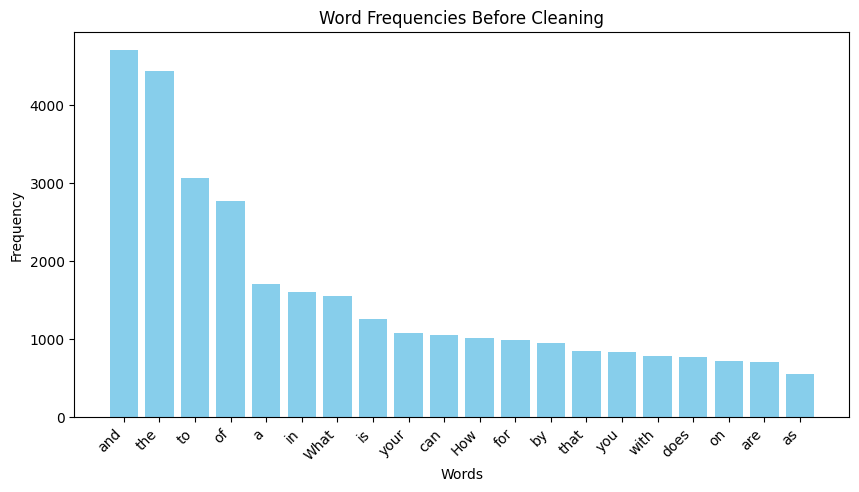

In [ ]:
plot_word_frequencies(raw_train_text, "Word Frequencies Before Cleaning")

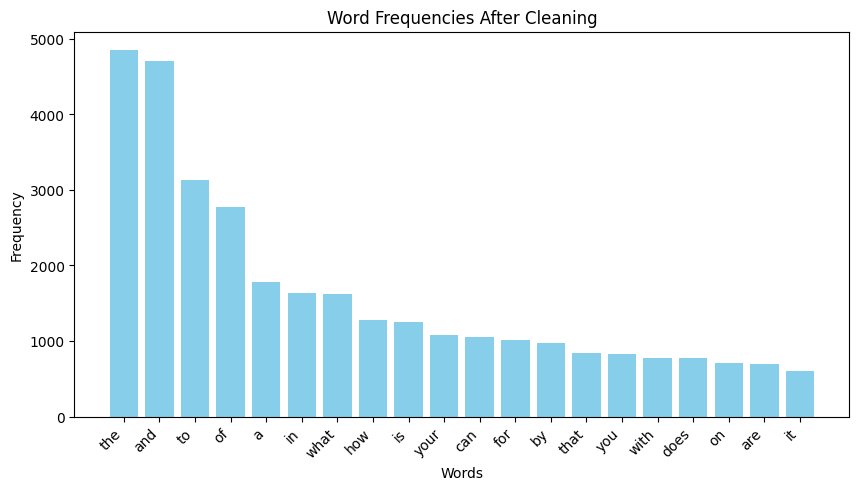

In [ ]:
plot_word_frequencies(cleaned_train_text, "Word Frequencies After Cleaning")

نلاحظ من الشكلين السابقين ان هناك اختلاف في بعض نسب ظهور الكلمات بعد اجراء عمليات التنظيف على البيانات

------------------------------------------------

مقارنة الكلمات الفريدة قبل و بعد التنظيف

In [ ]:
def plot_unique_word_count(raw_text: str, cleaned_text: str):
    """
    Compare unique word counts before and after cleaning.
    """
    raw_unique_count = len(set(raw_text.split()))
    cleaned_unique_count = len(set(cleaned_text.split()))

    plt.figure(figsize=(8, 5))
    plt.bar(['Before Cleaning', 'After Cleaning'], [raw_unique_count, cleaned_unique_count], color=['red', 'green'])
    plt.title("Unique Word Count Comparison")
    plt.ylabel("Count")
    plt.show()

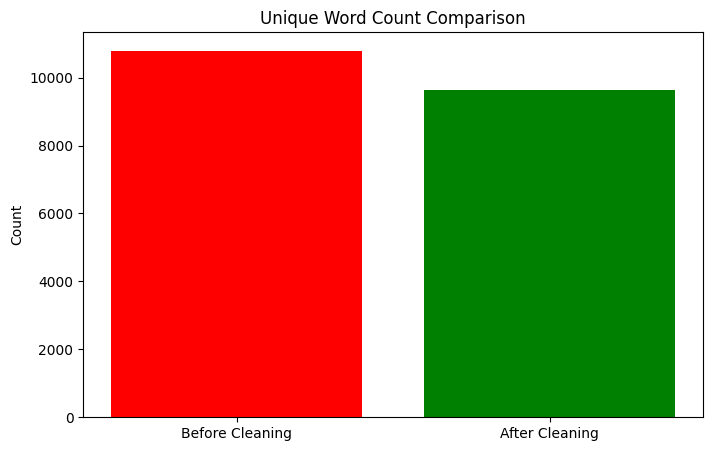

In [ ]:
plot_unique_word_count(raw_train_text, cleaned_train_text)

نلاحظ نقصان كمية الكلمات الفريدة بعد التنظيف

## Baseline Model

### Preparing Data

In [ ]:
train_questions = dataset_dict['train']['Question']
train_answers = dataset_dict['train']['Answer']
train_topics = dataset_dict['train']['Topic']

In [ ]:
# تنظيف و دمج الاسئلة مع المواضيع
def combine_question_topic(question, topic):
    return f"[{topic}] {question}"

cleaned_train_questions_with_topics = [
    combine_question_topic(clean_text(q), t)
    for q, t in zip(train_questions, train_topics)
]

In [ ]:
print(dataset_dict['validation'][:3])
print(type(dataset_dict['validation']))

{'Question': ['How can you make sure your goals are challenging yet achievable?', 'What’s the best way to include personal projects on your resume?', "What should you do if you're asked a question about a gap in your skills or knowledge?"], 'Answer': ['Set goals that push you to grow but are still within your capacity to achieve. Balance ambition with realism by assessing your current resources and capabilities and setting goals that stretch your limits without being unattainable.', "Include personal projects in a separate section such as 'Projects' or 'Personal Projects.' Describe the project, your role, and any relevant skills or technologies used. Highlight any results or achievements to show the impact and relevance of the project.", 'Acknowledge the gap honestly and focus on how you’re addressing it. Mention any steps you’re taking to improve, such as courses, certifications, or self-study, and how you’re applying new knowledge to your work.'], 'Topic': ['Business', 'Business', 'B

In [ ]:
# إعادة هيكلة البيانات إلى قائمة القواميس
validation_data = [
    {'Question': q, 'Answer': a, 'Topic': t}
    for q, a, t in zip(dataset_dict['validation']['Question'], dataset_dict['validation']['Answer'], dataset_dict['validation']['Topic'])
]
dataset_dict['validation'] = validation_data

### Model Initializing

In [ ]:
baseline_model = SentenceTransformer('all-MiniLM-L6-v2')

إنشاء تضمينات للأسئلة ذات المواضيع

In [ ]:
question_embeddings = baseline_model.encode(cleaned_train_questions_with_topics)
print(f"Embedding shape: {question_embeddings.shape}")

Embedding shape: (2591, 384)


In [ ]:
def get_baseline_answer(query, topic, threshold=0.6):
    """Get answer using baseline model with topic consideration."""
    # Combine query with topic
    query_with_topic = combine_question_topic(clean_text(query), topic)
    query_embedding = baseline_model.encode([query_with_topic])

    # حساب التشابه
    similarities = cosine_similarity(query_embedding, question_embeddings)[0]
    max_sim_idx = np.argmax(similarities)

    if similarities[max_sim_idx] >= threshold:
        return train_answers[max_sim_idx], similarities[max_sim_idx]
    return "Sorry, I cannot answer this question.", similarities[max_sim_idx]

### Evaluation

Styling function

In [1]:
def style_and_display(df, max_rows=10):
    styled_df = df.head(max_rows).style.set_table_styles(
        [
            {"selector": "th", "props": [("text-align", "center"), ("background-color", "#f4f4f4"), ("border", "1px solid black")]},
            {"selector": "td", "props": [("text-align", "center"), ("border", "1px solid black")]}
        ]
    ).set_properties(**{"text-align": "center"})

    display(styled_df)

Comparison Table

In [23]:
comparison_table = {
    "Model_Name": [],
    "Model_Epochs": [],
    "Testing on": [],
    "Preprocessing_Methods": [],
    "Rouge1": [],
    "Rouge2": [],
    "RougeL": [],
    "Bleu": [],
    "Bert_Precision": [],
    "Bert_Recall": [],
    "Bert_f1": []
}

In [ ]:
def generate_baseline_answers(test_dataset, baseline_model, question_embeddings, train_answers, threshold=0.6):
    generated_answers = []
    similarities = []

    for example in test_dataset:
        query = example['Question']
        topic = example['Topic']
        answer, similarity = get_baseline_answer(query, topic, threshold)
        generated_answers.append(answer)
        similarities.append(similarity)

    return generated_answers, similarities

#### Rogue, Bleu, Bert

In [ ]:
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge1': [], 'rouge2': [], 'rougeL': []
    }

    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)
        for key in scores:
            scores[key].append(score[key].fmeasure)

    return {k: np.mean(v) for k, v in scores.items()}

def calculate_bleu_score(predictions, references):
    # تقطيع التوقعات والمراجع
    smooth = SmoothingFunction()

    tokenized_refs = [[ref.split()] for ref in references]
    tokenized_preds = [pred.split() for pred in predictions]

    return corpus_bleu(tokenized_refs, tokenized_preds,
                      smoothing_function=smooth.method1)

def calculate_bert_score(predictions, references):
    P, R, F1 = score(predictions, references, lang='en', verbose=False)
    return {
        'precision': P.mean().item(),
        'recall': R.mean().item(),
        'f1': F1.mean().item()
    }

In [ ]:
def evaluate_baseline_model(test_dataset, baseline_model, question_embeddings, train_answers, threshold=0.7):

    predictions, similarities = generate_baseline_answers(
        test_dataset,
        baseline_model,
        question_embeddings,
        train_answers,
        threshold
    )
    references = [example['Answer'] for example in test_dataset]

    results = {
        'rouge': calculate_rouge_scores(predictions, references),
        'bleu': calculate_bleu_score(predictions, references),
        'bert_score': calculate_bert_score(predictions, references)
    }

    # استخراج بيانات الاختبار للمقارنة
    detailed_results = pd.DataFrame({
        'Topic': [example['Topic'] for example in test_dataset],
        'Question': [example['Question'] for example in test_dataset],
        'Reference': references,
        'Prediction': predictions,
        'Similarity_Score': similarities
    })

    return results, detailed_results

#### Testing

In [ ]:
print("\nTesting baseline model on validation examples:")
for i, example in enumerate(dataset_dict['validation'][:3]):
    query = example['Question']
    topic = example['Topic']
    true_answer = example['Answer']
    predicted_answer, similarity = get_baseline_answer(query, topic)

    print(f"\nExample {i+1}:")
    print(f"Topic: {topic}")
    print(f"Question: {query}")
    print(f"Predicted Answer: {predicted_answer}")
    print(f"True Answer: {true_answer}")
    print(f"Similarity Score: {similarity:.4f}")


Testing baseline model on validation examples:

Example 1:
Topic: Business
Question: How can you make sure your goals are challenging yet achievable?
Predicted Answer: Ensure your goals are specific by clearly defining what you want to achieve, how you plan to do it, and what success looks like. Avoid vague language and include detailed steps or criteria to measure progress.
True Answer: Set goals that push you to grow but are still within your capacity to achieve. Balance ambition with realism by assessing your current resources and capabilities and setting goals that stretch your limits without being unattainable.
Similarity Score: 0.8881

Example 2:
Topic: Business
Question: What’s the best way to include personal projects on your resume?
Predicted Answer: Use the STAR method to describe the project. Detail the Situation, Task, Action, and Results, highlighting your role and the positive impact of the project. Emphasize skills and achievements demonstrated through the project.
True

نلاحظ تفاوت في قيم التشابه بين الجواب الاصلي من الداتا و الجواب المتنبأ

------------------------------------------------------------------------

In [ ]:
# تقييم النموذج
test_dataset = dataset_dict['test']
results, detailed_results = evaluate_baseline_model(
    test_dataset,
    baseline_model,
    question_embeddings,
    train_answers
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("\nBaseline Model Evaluation Results:")
print("\nROUGE Scores:")
for key, value in results['rouge'].items():
    print(f"{key}: {value:.4f}")

print(f"\nBLEU Score: {results['bleu']:.4f}")

print("\nBERTScore:")
for key, value in results['bert_score'].items():
    print(f"{key}: {value:.4f}")


Baseline Model Evaluation Results:

ROUGE Scores:
rouge1: 0.3481
rouge2: 0.1415
rougeL: 0.2712

BLEU Score: 0.1001

BERTScore:
precision: 0.8942
recall: 0.8932
f1: 0.8936


In [24]:
comparison_table["Model_Name"].append("SentenceTransformer 'all-MiniLM-L6-v2' ")
comparison_table["Model_Epochs"].append("default")
comparison_table["Preprocessing_Methods"].append("clean_text_function")
comparison_table["Testing on"].append("Test Data")
comparison_table["Rouge1"].append(0.3481)
comparison_table["Rouge2"].append(0.1415)
comparison_table["RougeL"].append(0.2712)
comparison_table["Bleu"].append(0.1001)
comparison_table["Bert_Precision"].append(0.8942)
comparison_table["Bert_Recall"].append(0.8932)
comparison_table["Bert_f1"].append(0.8936)

In [25]:
df = pd.DataFrame(comparison_table)

print(style_and_display(df))

,Model_Name,Model_Epochs,Testing on,Preprocessing_Methods,Rouge1,Rouge2,RougeL,Bleu,Bert_Precision,Bert_Recall,Bert_f1
0,SentenceTransformer 'all-MiniLM-L6-v2',default,Test Data,clean_text_function,0.348100,0.141500,0.271200,0.100100,0.894200,0.893200,0.893600


None


نلاحظ ارتفاع نسب

BERT

وانخفاض نسب

Rogue , Bleu

هذا يشير إلى أن النموذج قادر على فهم المعاني الكامنة للنصوص، ولكنه يفشل في توليد نصوص مطابقة بشكل جيد للتسلسل أو التركيب المرجعي

## FineTuning Llama 3.1-8B

### Initializing Llama model

In [ ]:
max_seq_length = 2048
dtype = None # None for auto detection.
load_in_4bit = True # 4bit quantization to reduce memory usage.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.1.6: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

### Prompt Format

In [ ]:
def format_prompt(Question: str, Answer: str, Topic: str, eos_token: str) -> str:
    template = (
        f"The following is a conversation between a student and an AI tutor specialized in {Topic}. "
        "The AI tutor provides accurate and helpful answers based on its expertise.\n\n"
        f"Topic: {Topic}\n"
        f"Question:\n{Question}\n\nAnswer:\n{Answer}"
    )
    return template + eos_token

### Dataset Formatting

In [ ]:
def format_dataset(examples):
    return {
        "text": [
            format_prompt(q, a, t, tokenizer.eos_token)
            for q, a, t in zip(examples["Question"], examples["Answer"], examples["Topic"])
        ]
    }

In [ ]:
cleaned_train = Dataset.from_dict({
    "Question": [clean_text(item["Question"]) for item in dataset_dict['train']],
    "Answer": [clean_text(item["Answer"]) for item in dataset_dict['train']],
    "Topic": [item["Topic"] for item in dataset_dict['train']]
})

formatted_datasets = DatasetDict({
    'train': cleaned_train.map(format_dataset, batched=True),
    **{
        split: Dataset.from_dict({
            "Question": [item["Question"] for item in dataset],
            "Answer": [item["Answer"] for item in dataset],
            "Topic": [item["Topic"] for item in dataset]
        }).map(format_dataset, batched=True)
        for split, dataset in dataset_dict.items()
        if split != 'train'
    }
})

Map:   0%|          | 0/2591 [00:00<?, ? examples/s]

Map:   0%|          | 0/458 [00:00<?, ? examples/s]

Map:   0%|          | 0/458 [00:00<?, ? examples/s]

In [ ]:
print("\nExample of formatted training data:")
print(formatted_datasets['train'][0]['text'])


Example of formatted training data:
The following is a conversation between a student and an AI tutor specialized in Business. The AI tutor provides accurate and helpful answers based on its expertise.

Topic: Business
Question:
how can a team member ensure their opinion is heard during discusions?

Answer:
ensure your opinion is heard by preparing your points in advance, actively participating in discusions, and engaging with the meting facilitator. use concise and clear comunication, and dont hesitate to asert your perspective respectfuly.<|end_of_text|>


### Training

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps = 4,
    warmup_steps = 5,
    #num_train_epochs = 2,
    max_steps = 60,
    eval_steps=10,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    learning_rate = 2e-4,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = "outputs",
    report_to = "none",
)

2 EPOCHS

In [ ]:
# training_args = TrainingArguments(
#     per_device_train_batch_size = 2,
#     per_device_eval_batch_size=2,
#     gradient_accumulation_steps = 4,
#     warmup_steps = 5,
#     num_train_epochs = 2,
#     #max_steps = 120,
#     eval_steps=50,
#     eval_strategy="steps",
#     save_strategy="steps",
#     save_steps=20,
#     learning_rate = 2e-4,
#     fp16 = not is_bfloat16_supported(),
#     bf16 = is_bfloat16_supported(),
#     logging_steps = 1,
#     optim = "adamw_8bit",
#     weight_decay = 0.01,
#     lr_scheduler_type = "linear",
#     seed = 3407,
#     output_dir = "outputs",
#     report_to = "none",
# )

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset=formatted_datasets['train'],
    eval_dataset=formatted_datasets['validation'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = training_args
)

Map (num_proc=2):   0%|          | 0/2591 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/458 [00:00<?, ? examples/s]

60 STEPS

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,591 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
10,1.509800,1.262321
20,1.036300,1.089431
30,0.909600,1.099769
40,1.033700,1.061345
50,1.050500,1.066422
60,0.890800,1.085838


TrainOutput(global_step=60, training_loss=1.2537276496489842, metrics={'train_runtime': 895.8662, 'train_samples_per_second': 0.536, 'train_steps_per_second': 0.067, 'total_flos': 2052687642722304.0, 'train_loss': 1.2537276496489842, 'epoch': 0.18518518518518517})

1 FULL EPOCH

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,802 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 350
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
35,0.948600,1.034455
70,0.747500,1.062540
105,0.832700,1.047815
140,0.910300,1.068763
175,0.863500,1.094040
210,0.796800,1.057985
245,0.731600,1.086304
280,0.760500,1.135788
315,0.859900,1.077395
350,0.567900,1.088213


TrainOutput(global_step=350, training_loss=0.8292027407033102, metrics={'train_runtime': 2228.2713, 'train_samples_per_second': 1.257, 'train_steps_per_second': 0.157, 'total_flos': 1.1886497771225088e+16, 'train_loss': 0.8292027407033102, 'epoch': 0.9992862241256245})

2 EPOCHS

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,591 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 648
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
50,1.028500,1.166531
100,1.101200,1.082587
150,0.922900,1.100758
200,0.913100,1.147021
250,0.855500,1.158009
300,0.881600,1.091292
350,0.592900,1.198151
400,0.576400,1.197424
450,0.581200,1.157084
500,0.529900,1.160450


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=648, training_loss=0.7311531412472696, metrics={'train_runtime': 4608.7327, 'train_samples_per_second': 1.124, 'train_steps_per_second': 0.141, 'total_flos': 2.2044385493016576e+16, 'train_loss': 0.7311531412472696, 'epoch': 2.0})

#### Learning Curves

In [ ]:
def plot_losses(train_steps, train_losses, val_losses, title='Training and Validation Loss Over Time'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_losses, label='Training Loss')
    plt.plot(train_steps, val_losses, label='Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

60 STEPS

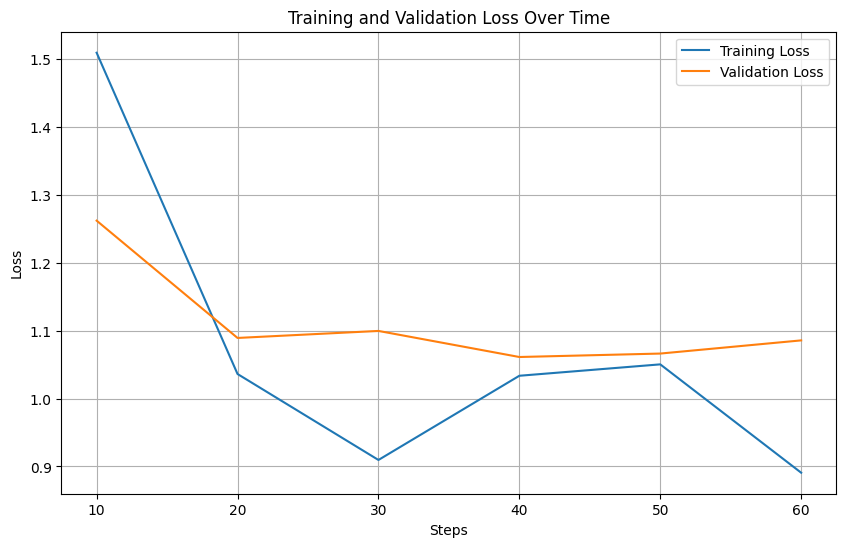

In [ ]:
train_steps = [10, 20, 30, 40, 50, 60]
train_losses = [1.509800, 1.036300, 0.909600, 1.033700, 1.050500, 0.890800]
val_losses = [1.262321, 1.089431, 1.099769, 1.061345, 1.066422, 1.085838]

plot_losses(train_steps, train_losses, val_losses)

1 FULL EPOCH

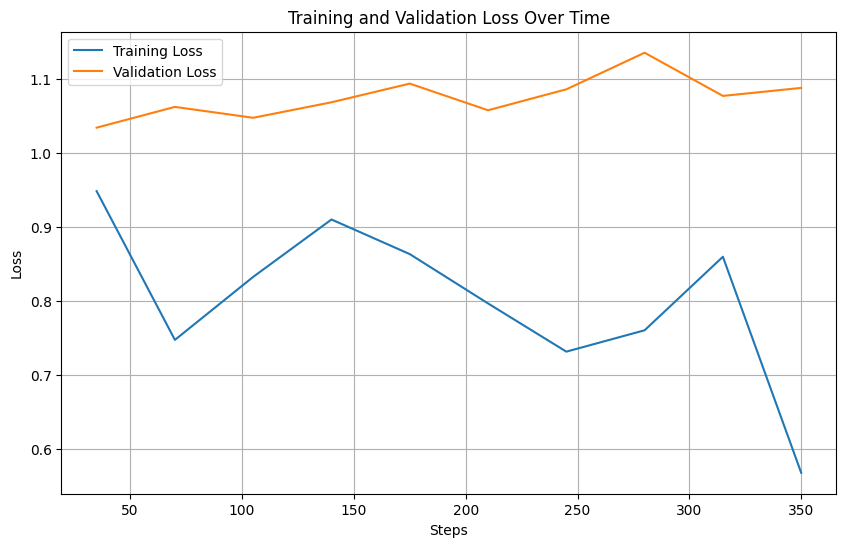

In [ ]:
train_steps = [35, 70, 105, 140, 175, 210, 245, 280, 315, 350]
train_losses = [0.948600, 0.747500, 0.832700, 0.910300, 0.863500, 0.796800, 0.731600, 0.760500, 0.859900, 0.567900]
val_losses = [1.034455, 1.062540, 1.047815, 1.068763, 1.094040, 1.057985, 1.086304, 1.135788, 1.077395, 1.088213]

plot_losses(train_steps, train_losses, val_losses)

2 EPOCHS

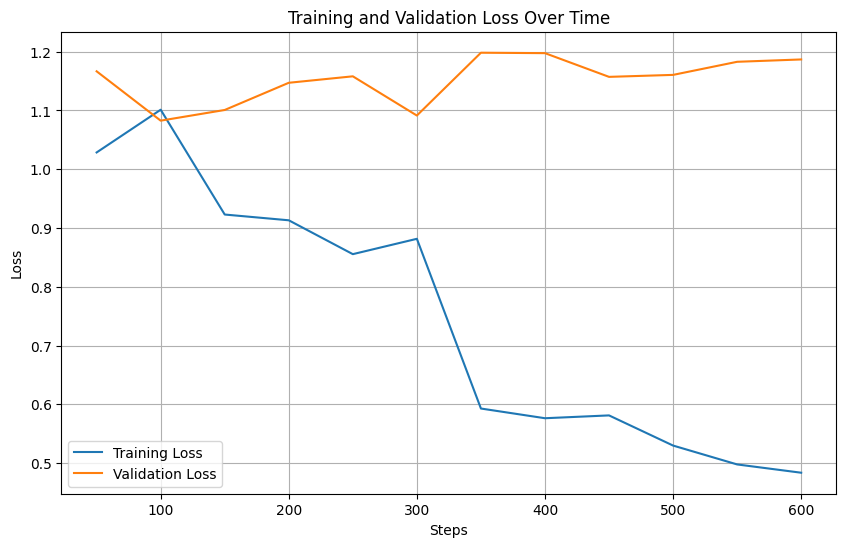

In [ ]:
train_steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
train_losses = [1.028500, 1.101200, 0.922900, 0.913100, 0.855500, 0.881600, 0.592900, 0.576400, 0.581200, 0.529900, 0.497800, 0.483700]
val_losses = [1.166531, 1.082587, 1.100758, 1.147021, 1.158009, 1.091292, 1.198151, 1.197424, 1.157084, 1.160450, 1.182714, 1.186705]

plot_losses(train_steps, train_losses, val_losses)

نلاحظ وجود

OverFitting

### Evaluation

نجعل النموذج يولد اجوبة عن الاسئلة ومقارنتها مع الاجوبة في البيانات

In [ ]:
def generate_answers(model, tokenizer, test_dataset, max_length=512):
    model.eval()
    generated_answers = []

    with torch.no_grad():
        for example in test_dataset:
            prompt = f"The following is a conversation between a student and an AI tutor specialized in {example['Topic']}. The AI tutor provides accurate and helpful answers based on its expertise.\n\nTopic: {example['Topic']}\nQuestion:\n{example['Question']}\n\nAnswer:\n"

            inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)

            outputs = model.generate(
                **inputs,
                max_length=max_length,
                num_return_sequences=1,
                temperature=0.7,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
            )

            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            # استخراج الجواب
            answer = generated_text.split("Answer:\n")[-1].strip()
            generated_answers.append(answer)

    return generated_answers

In [ ]:
def evaluate_model(model, tokenizer, test_dataset):

    FastLanguageModel.for_inference(model)

    predictions = generate_answers(model, tokenizer, test_dataset)
    references = [example['Answer'] for example in test_dataset]

    results = {
        'rouge': calculate_rouge_scores(predictions, references),
        'bleu': calculate_bleu_score(predictions, references),
        'bert_score': calculate_bert_score(predictions, references)
    }

    detailed_results = pd.DataFrame({
        'Topic': [example['Topic'] for example in test_dataset],
        'Question': [example['Question'] for example in test_dataset],
        'Reference': references,
        'Prediction': predictions
    })

    return results, detailed_results

#### Testing

60 STEPS

In [ ]:
test_dataset = formatted_datasets['test']
results, detailed_results = evaluate_model(model, tokenizer, test_dataset)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("\nFine-tuned Model Evaluation Results:")
print("\nROUGE Scores:")
for key, value in results['rouge'].items():
    print(f"{key}: {value:.4f}")

print(f"\nBLEU Score: {results['bleu']:.4f}")

print("\nBERTScore:")
for key, value in results['bert_score'].items():
    print(f"{key}: {value:.4f}")


Fine-tuned Model Evaluation Results:

ROUGE Scores:
rouge1: 0.4332
rouge2: 0.1578
rougeL: 0.3251

BLEU Score: 0.0749

BERTScore:
precision: 0.9075
recall: 0.9035
f1: 0.9054


In [26]:
comparison_table["Model_Name"].append("Fine-tuned Llama3.1-8B Model")
comparison_table["Model_Epochs"].append("60 Steps (0.2 epoch)")
comparison_table["Preprocessing_Methods"].append("clean_text_function")
comparison_table["Testing on"].append("Test Data")
comparison_table["Rouge1"].append(0.4332)
comparison_table["Rouge2"].append(0.1578)
comparison_table["RougeL"].append(0.3251)
comparison_table["Bleu"].append(0.0749)
comparison_table["Bert_Precision"].append(0.9075)
comparison_table["Bert_Recall"].append(0.9035)
comparison_table["Bert_f1"].append(0.9054)

In [ ]:
print("\nExample Predictions:")
for i in range(min(3, len(detailed_results))):
    print(f"\nExample {i+1}:")
    print(f"Topic: {detailed_results.iloc[i]['Topic']}")
    print(f"Question: {detailed_results.iloc[i]['Question']}")
    print(f"Prediction: {detailed_results.iloc[i]['Prediction']}")
    print(f"Reference: {detailed_results.iloc[i]['Reference']}")


Example Predictions:

Example 1:
Topic: Business
Question: How can I deal with unexpected interruptions during work?
Prediction: handle unexpected interruptions by acknowledging them politely, prioritizing the task at hand, and adresing the interruption once its adresed. maintain focus on the task and adres the interruption in a timely manner to ensure continuity.
Reference: Deal with unexpected interruptions by setting boundaries, such as designated 'focus times' when you are unavailable for non-urgent matters. Address interruptions quickly, if possible, and return to your work with minimal disruption by using techniques like time blocking.

Example 2:
Topic: Business
Question: What does the episode say about emotional trust versus cognitive trust?
Prediction: the episode says that emotional trust is based on gut feelings and personal connections, while cognitive trust is based on logic and facts.
Reference: Emotional trust is influenced by gut instincts and feelings, while cognitive

1 FULL EPOCH

In [ ]:
test_dataset = formatted_datasets['test']
results, detailed_results = evaluate_model(model, tokenizer, test_dataset)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("\nFine-tuned Model Evaluation Results:")
print("\nROUGE Scores:")
for key, value in results['rouge'].items():
    print(f"{key}: {value:.4f}")

print(f"\nBLEU Score: {results['bleu']:.4f}")

print("\nBERTScore:")
for key, value in results['bert_score'].items():
    print(f"{key}: {value:.4f}")


Fine-tuned Model Evaluation Results:

ROUGE Scores:
rouge1: 0.4582
rouge2: 0.1923
rougeL: 0.3578

BLEU Score: 0.1045

BERTScore:
precision: 0.8951
recall: 0.9053
f1: 0.9000


In [27]:
comparison_table["Model_Name"].append("Fine-tuned Llama3.1-8B Model")
comparison_table["Model_Epochs"].append("1 Full Epoch")
comparison_table["Preprocessing_Methods"].append("clean_text_function")
comparison_table["Testing on"].append("Test Data")
comparison_table["Rouge1"].append(0.4582)
comparison_table["Rouge2"].append(0.1923)
comparison_table["RougeL"].append(0.3578)
comparison_table["Bleu"].append(0.1045)
comparison_table["Bert_Precision"].append(0.8951)
comparison_table["Bert_Recall"].append(0.9053)
comparison_table["Bert_f1"].append(0.9000)

In [ ]:
print("\nExample Predictions:")
for i in range(min(3, len(detailed_results))):
    print(f"\nExample {i+1}:")
    print(f"Topic: {detailed_results.iloc[i]['Topic']}")
    print(f"Question: {detailed_results.iloc[i]['Question']}")
    print(f"Prediction: {detailed_results.iloc[i]['Prediction']}")
    print(f"Reference: {detailed_results.iloc[i]['Reference']}")


Example Predictions:

Example 1:
Topic: Business
Question: How can I deal with unexpected interruptions during work?
Prediction: dealing with unexpected interruptions requires staying focused and managing distractions. use techniques like seting aside time for interruptions, seting boundaries, and returning to tasks after handling the interuption.
Reference: Deal with unexpected interruptions by setting boundaries, such as designated 'focus times' when you are unavailable for non-urgent matters. Address interruptions quickly, if possible, and return to your work with minimal disruption by using techniques like time blocking.

Example 2:
Topic: Business
Question: What does the episode say about emotional trust versus cognitive trust?
Prediction: the episode says that emotional trust is based on personal experiences and interactions, while cognitive trust is based on the believability of facts and data.
Reference: Emotional trust is influenced by gut instincts and feelings, while cognit

Testing on Train Data

In [ ]:
test_dataset = formatted_datasets['train'].select(range(100))

results, detailed_results = evaluate_model(model, tokenizer, test_dataset)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("\nFine-tuned Model Evaluation Results:")
print("\nROUGE Scores:")
for key, value in results['rouge'].items():
    print(f"{key}: {value:.4f}")

print(f"\nBLEU Score: {results['bleu']:.4f}")

print("\nBERTScore:")
for key, value in results['bert_score'].items():
    print(f"{key}: {value:.4f}")


Fine-tuned Model Evaluation Results:

ROUGE Scores:
rouge1: 0.4818
rouge2: 0.2075
rougeL: 0.3728

BLEU Score: 0.1115

BERTScore:
precision: 0.8984
recall: 0.9117
f1: 0.9049


In [28]:
comparison_table["Model_Name"].append("Fine-tuned Llama3.1-8B Model")
comparison_table["Model_Epochs"].append("1 Full Epoch")
comparison_table["Preprocessing_Methods"].append("clean_text_function")
comparison_table["Testing on"].append("Train Data")
comparison_table["Rouge1"].append(0.4818)
comparison_table["Rouge2"].append(0.2075)
comparison_table["RougeL"].append(0.3728)
comparison_table["Bleu"].append(0.1115)
comparison_table["Bert_Precision"].append(0.8984)
comparison_table["Bert_Recall"].append(0.9117)
comparison_table["Bert_f1"].append(0.9049)

In [ ]:
print("\nExample Predictions:")
for i in range(min(3, len(detailed_results))):
    print(f"\nExample {i+1}:")
    print(f"Topic: {detailed_results.iloc[i]['Topic']}")
    print(f"Question: {detailed_results.iloc[i]['Question']}")
    print(f"Prediction: {detailed_results.iloc[i]['Prediction']}")
    print(f"Reference: {detailed_results.iloc[i]['Reference']}")


Example Predictions:

Example 1:
Topic: Business
Question: How can I deal with unexpected interruptions during work?
Prediction: dealing with unexpected interruptions involves maintaining focus, using a to do list to track tasks, and handling interuptions efectively by adresing them quickly and returning to your task asap.
Reference: Deal with unexpected interruptions by setting boundaries, such as designated 'focus times' when you are unavailable for non-urgent matters. Address interruptions quickly, if possible, and return to your work with minimal disruption by using techniques like time blocking.

Example 2:
Topic: Business
Question: What does the episode say about emotional trust versus cognitive trust?
Prediction: the episode says that emotional trust is based on how you fel about the other person, while cognitive trust is based on their competence, integrity, and reliability.
Reference: Emotional trust is influenced by gut instincts and feelings, while cognitive trust is based 

2 EPOCHS

In [ ]:
test_dataset = formatted_datasets['test']
results, detailed_results = evaluate_model(model, tokenizer, test_dataset)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("\nFine-tuned Model Evaluation Results:")
print("\nROUGE Scores:")
for key, value in results['rouge'].items():
    print(f"{key}: {value:.4f}")

print(f"\nBLEU Score: {results['bleu']:.4f}")

print("\nBERTScore:")
for key, value in results['bert_score'].items():
    print(f"{key}: {value:.4f}")


Fine-tuned Model Evaluation Results:

ROUGE Scores:
rouge1: 0.4618
rouge2: 0.1829
rougeL: 0.3558

BLEU Score: 0.0954

BERTScore:
precision: 0.8904
recall: 0.9076
f1: 0.8988


In [29]:
comparison_table["Model_Name"].append("Fine-tuned Llama3.1-8B Model")
comparison_table["Model_Epochs"].append("2 Full Epochs")
comparison_table["Preprocessing_Methods"].append("clean_text_function")
comparison_table["Testing on"].append("Test Data")
comparison_table["Rouge1"].append(0.4618)
comparison_table["Rouge2"].append(0.1829)
comparison_table["RougeL"].append(0.3558)
comparison_table["Bleu"].append(0.0954)
comparison_table["Bert_Precision"].append(0.8904)
comparison_table["Bert_Recall"].append(0.9076)
comparison_table["Bert_f1"].append(0.8988)

In [ ]:
print("\nExample Predictions:")
for i in range(min(3, len(detailed_results))):
    print(f"\nExample {i+1}:")
    print(f"Topic: {detailed_results.iloc[i]['Topic']}")
    print(f"Question: {detailed_results.iloc[i]['Question']}")
    print(f"Prediction: {detailed_results.iloc[i]['Prediction']}")
    print(f"Reference: {detailed_results.iloc[i]['Reference']}")


Example Predictions:

Example 1:
Topic: Business
Question: How can I deal with unexpected interruptions during work?
Prediction: deal with unexpected interruptions by seting boundaries, comunicating your focus to others, and using tols like noise canceling headphones or a closed doorknob to minimize distractions. if necesary, schedule regular breaks to recharge.
Reference: Deal with unexpected interruptions by setting boundaries, such as designated 'focus times' when you are unavailable for non-urgent matters. Address interruptions quickly, if possible, and return to your work with minimal disruption by using techniques like time blocking.

Example 2:
Topic: Business
Question: What does the episode say about emotional trust versus cognitive trust?
Prediction: emotional trust is based on personal felings and relationships, while cognitive trust is based on perceptions of competence, intent, and integrity.
Reference: Emotional trust is influenced by gut instincts and feelings, while cog

Testing on Train Data

In [ ]:
test_dataset = formatted_datasets['train'].select(range(100))

results, detailed_results = evaluate_model(model, tokenizer, test_dataset)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("\nFine-tuned Model Evaluation Results:")
print("\nROUGE Scores:")
for key, value in results['rouge'].items():
    print(f"{key}: {value:.4f}")

print(f"\nBLEU Score: {results['bleu']:.4f}")

print("\nBERTScore:")
for key, value in results['bert_score'].items():
    print(f"{key}: {value:.4f}")


Fine-tuned Model Evaluation Results:

ROUGE Scores:
rouge1: 0.5059
rouge2: 0.2665
rougeL: 0.4176

BLEU Score: 0.1607

BERTScore:
precision: 0.8981
recall: 0.9166
f1: 0.9072


بالنسبة الى بيانات الاختبار

نلاحظ ارتفاع نسب

BERT

وانخفاض نسب

Rogue , Bleu

هذا يشير إلى أن النموذج قادر على فهم المعاني الكامنة للنصوص، ولكنه يفشل في توليد نصوص مطابقة بشكل جيد للتسلسل أو التركيب المرجعي

اما بالنسبة الى الاختبار باستعمال بيانات التدريب

نلاحظ تحسن اكبر في نسب ال

Rogue , Bleu

In [30]:
comparison_table["Model_Name"].append("Fine-tuned Llama3.1-8B Model")
comparison_table["Model_Epochs"].append("2 Full Epochs")
comparison_table["Preprocessing_Methods"].append("clean_text_function")
comparison_table["Testing on"].append("Train Data")
comparison_table["Rouge1"].append(0.5059)
comparison_table["Rouge2"].append(0.2665)
comparison_table["RougeL"].append(0.4176)
comparison_table["Bleu"].append(0.1607)
comparison_table["Bert_Precision"].append(0.8981)
comparison_table["Bert_Recall"].append(0.9166)
comparison_table["Bert_f1"].append(0.9072)

##Final Comparison Table

In [31]:
df = pd.DataFrame(comparison_table)

print(style_and_display(df))

,Model_Name,Model_Epochs,Testing on,Preprocessing_Methods,Rouge1,Rouge2,RougeL,Bleu,Bert_Precision,Bert_Recall,Bert_f1
0,SentenceTransformer 'all-MiniLM-L6-v2',default,Test Data,clean_text_function,0.348100,0.141500,0.271200,0.100100,0.894200,0.893200,0.893600
1,Fine-tuned Llama3.1-8B Model,60 Steps (0.2 epoch),Test Data,clean_text_function,0.433200,0.157800,0.325100,0.074900,0.907500,0.903500,0.905400
2,Fine-tuned Llama3.1-8B Model,1 Full Epoch,Test Data,clean_text_function,0.458200,0.192300,0.357800,0.104500,0.895100,0.905300,0.900000
3,Fine-tuned Llama3.1-8B Model,1 Full Epoch,Train Data,clean_text_function,0.481800,0.207500,0.372800,0.111500,0.898400,0.911700,0.904900
4,Fine-tuned Llama3.1-8B Model,2 Full Epochs,Test Data,clean_text_function,0.461800,0.182900,0.355800,0.095400,0.890400,0.907600,0.898800
5,Fine-tuned Llama3.1-8B Model,2 Full Epochs,Train Data,clean_text_function,0.505900,0.266500,0.417600,0.160700,0.898100,0.916600,0.907200


None
